In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False, IT_only=True, area_threshold=0.1)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False,  IT_only=True)
    new_dict['shuff_cubelet']= fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, dummy_data=False, IT_only=True)
    new_dict['shuff_area']=fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True)
    new_dict['shuff_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

In [3]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob
def get_marginal_prob(matrix, columns):
    """ function to get the marginal probability for a neuron projecting to a given area (column)"""
    marginal_prob = {}
    for area in columns:
        marginal_prob[area] = matrix.astype(bool)[area].sum()/(len(matrix))

    return marginal_prob

In [4]:
def find_and_adjust_with_epsilon(conditional_probs, marginal_probs):
    """Function to find epsilon value to add to probabilities so you don't get inf/nan"""
    min_positive_prob_cond = conditional_probs[conditional_probs > 0].min().min()
    min_positive_prob_marginal = float('inf')
    if isinstance(marginal_probs, (pd.DataFrame, pd.Series)):
        min_positive_prob_marginal = marginal_probs[marginal_probs > 0].min().min()
    elif isinstance(marginal_probs, dict):
        positive_values = [v for v in marginal_probs.values() if v > 0]
        if positive_values:
            min_positive_prob_marginal = min(positive_values)
    else:
        raise TypeError("marginal_probs must be a pandas DataFrame, Series, or dictionary.")
    
    min_positive_prob = min(min_positive_prob_cond, min_positive_prob_marginal)
    fraction = 0.1  
    epsilon = fraction * min_positive_prob
    cond_prob_adjusted = conditional_probs.clip(lower=epsilon, upper=1 - epsilon)
    if isinstance(marginal_probs, (pd.DataFrame, pd.Series)):
        marginal_adjusted = marginal_probs.clip(lower=epsilon, upper=1 - epsilon)
    elif isinstance(marginal_probs, dict):
        marginal_adjusted = {
            k: min(max(v, epsilon), 1 - epsilon) for k, v in marginal_probs.items()
        }
    
    return cond_prob_adjusted, marginal_adjusted

In [5]:
odds_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
for key in analysis_names:
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix_to_comp = all_combined[key].copy()
    all_cols = matrix_to_comp.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    actual_cond_prob = get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered) 
    actual_marginal = get_marginal_prob(matrix=matrix_to_comp, columns=cols_reordered)
    actual_cond_prob_adjusted, actual_marginal_adjusted = find_and_adjust_with_epsilon(conditional_probs= actual_cond_prob, marginal_probs=actual_marginal)
    cond_prob_odds =  actual_cond_prob_adjusted/(1-actual_cond_prob_adjusted)
    odds_ratio_actual = pd.DataFrame(index=cond_prob_odds.index)
    for col in actual_cond_prob.columns:
        odds_marginal = actual_marginal_adjusted[col]/(1-actual_marginal_adjusted[col])
        odds_ratio_actual[col] = np.log2(cond_prob_odds[col]/odds_marginal)

    #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in key]
    which = which_type[0]
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
    shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    extracted_names = [name.split(", ")[-1].strip("']") for name in shuffled_cond_prob.columns]
    shuff_marginal = shuffled_numbers[extracted_names].div(shuffle_total_numbers[0], axis=0)
    shuffled_cond_prob_adjusted, shuff_marginal_adjusted = find_and_adjust_with_epsilon(conditional_probs= shuffled_cond_prob, marginal_probs=shuff_marginal)
    shuff_odds_cond_prob = shuffled_cond_prob_adjusted / (1 - shuffled_cond_prob_adjusted)
    shuff_odds_marginal = shuff_marginal_adjusted / (1 - shuff_marginal_adjusted)
    shuff_odds_cond_prob = shuff_odds_cond_prob.apply(pd.to_numeric, errors='coerce')
    shuff_odds_marginal = shuff_odds_marginal.apply(pd.to_numeric, errors='coerce')
    result_array = np.log2(shuff_odds_cond_prob.to_numpy() / shuff_odds_marginal.to_numpy())
    shuff_log_odds_ratio = pd.DataFrame(result_array, index=shuff_odds_cond_prob.index, columns=shuff_odds_cond_prob.columns)
    
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for column_name in shuff_log_odds_ratio.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols and separated_words[1] in cols_reordered:
            mean_odds_ratio = shuff_log_odds_ratio[column_name].mean()
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_odds_ratio
            #mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_cosine
            val_to_comp = odds_ratio_actual.loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_odds_ratio:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuff_log_odds_ratio[column_name] if value > val_to_comp)/len(shuff_log_odds_ratio))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_odds_ratio:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuff_log_odds_ratio[column_name] if value < val_to_comp)/len(shuff_log_odds_ratio))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val    
            
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_val_dict[key] =p_val_matrix
    odds_dict[key] =odds_ratio_actual
    odds_dict[f'{key}_shuffled'] =mean_val_matrix


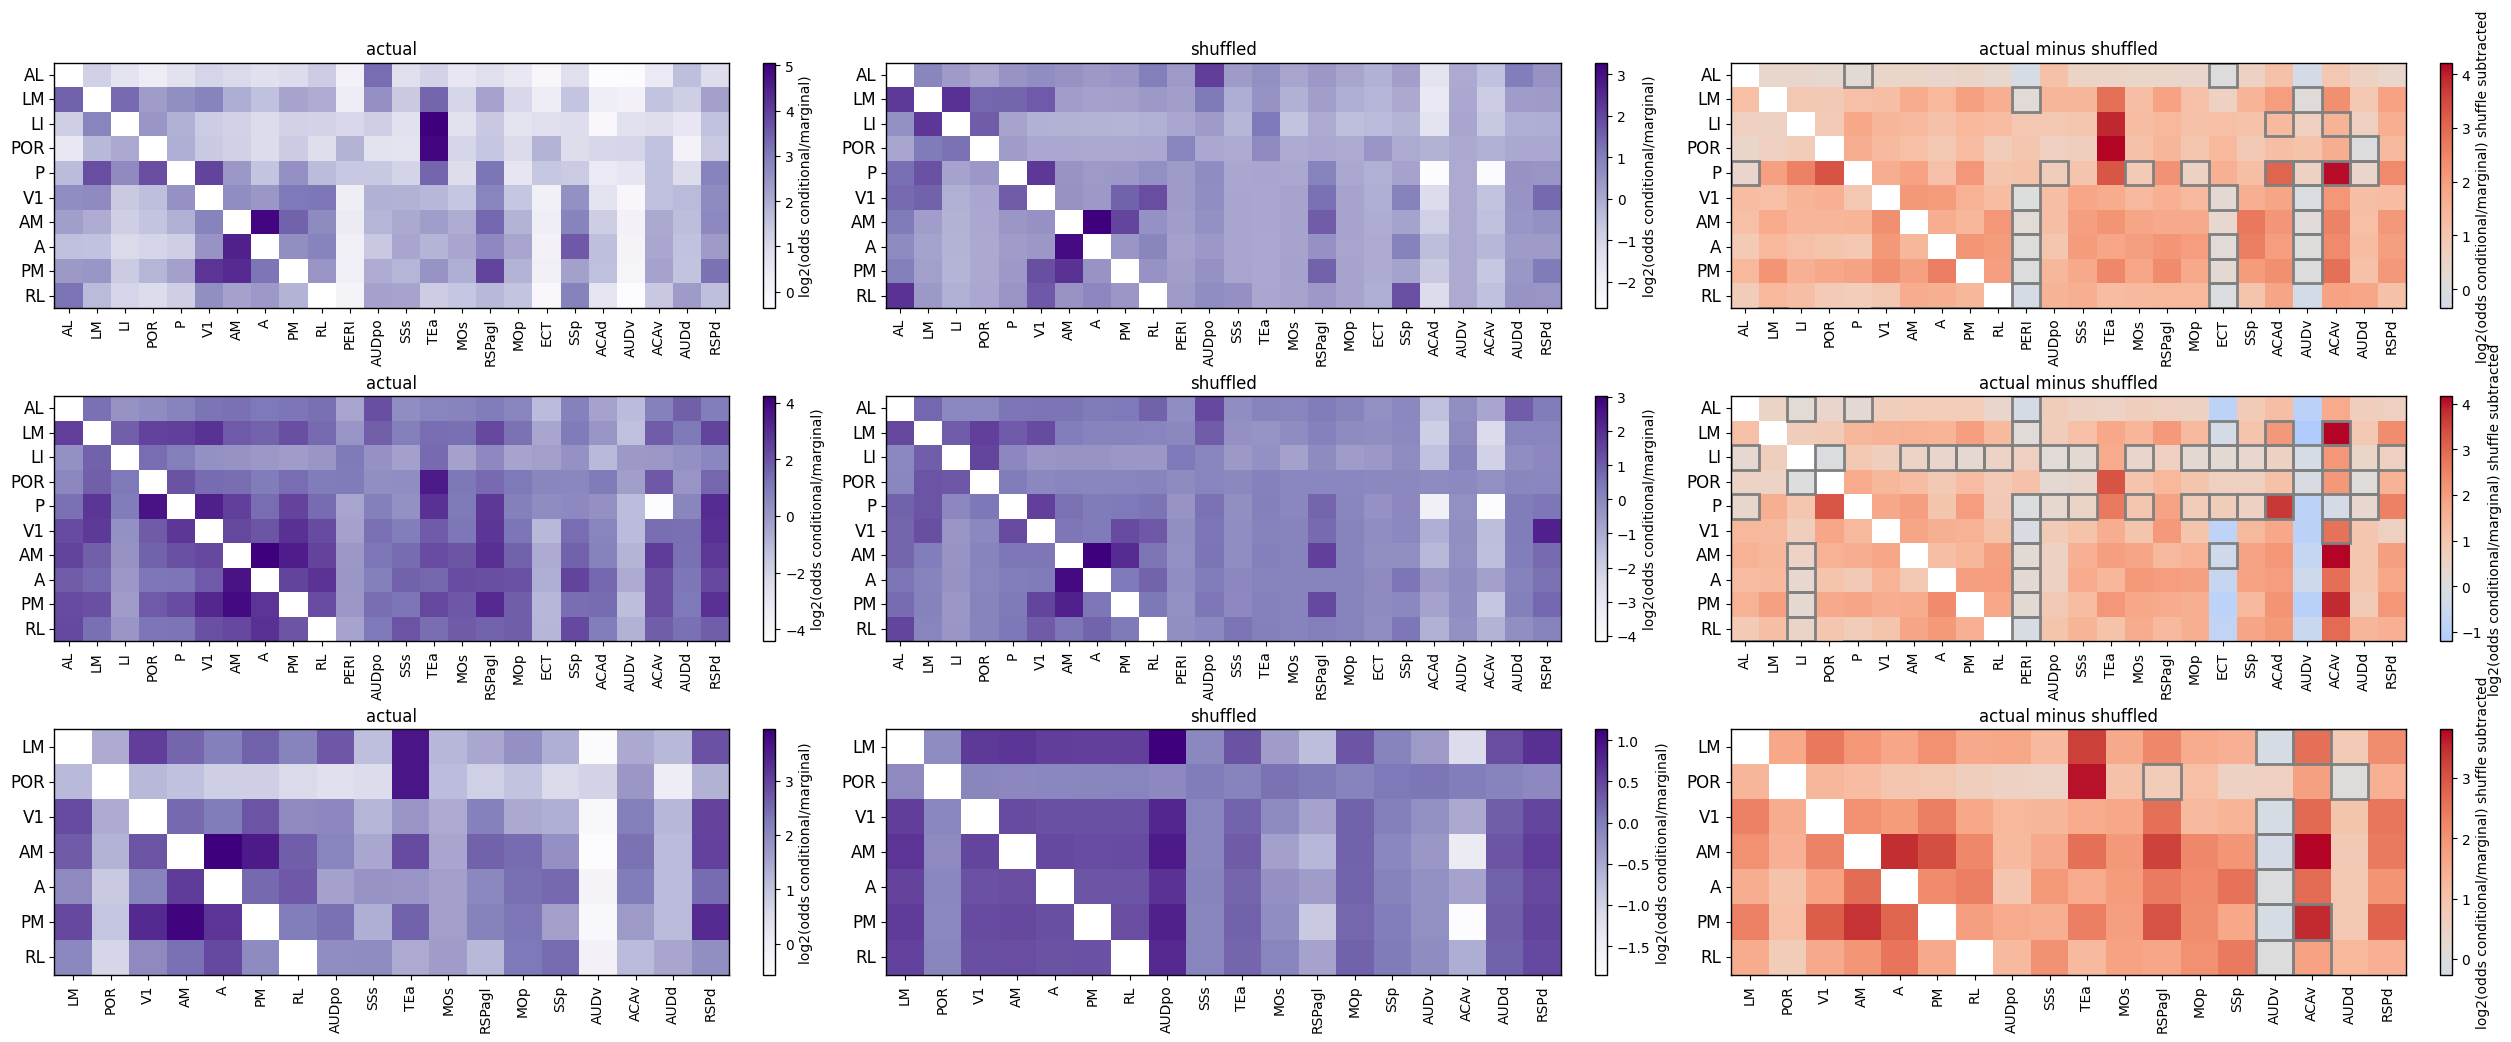

In [19]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 3, figsize=(25, 10), constrained_layout=True)
prob_dict_minus_shuff = {}
titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(analysis_names):
    actual_data= odds_dict[analysis_type]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in actual_data.columns]
    dfs = [actual_data, odds_dict[f'{analysis_type}_shuffled'], actual_data-odds_dict[f'{analysis_type}_shuffled']]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            prob_dict_minus_shuff[analysis_type] = shortened_data.copy(deep=True)
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal) shuffle subtracted'})
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal)'})
        axs[analysis_num, number].set_title(f'{titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        
        if number>1:
            for ii in data_to_use.index:
                for j in data_to_use.columns:
                    if p_val_dict[analysis_type].loc[ii, j] > 0.05:
                        row_idx = data_to_use.index.get_loc(ii)  # get the index of the row name
                        col_idx = data_to_use.columns.get_loc(j)  
                        axs[analysis_num, number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [20]:
def get_cosine_sim_of_probs(matrix, cols):
    cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for col in cols:
        for col_2 in cols:
            neurons_1 = matrix.loc[col]
            neurons_2 = matrix.loc[col_2]
            neurons_1 =neurons_1.drop([col, col_2])
            neurons_2 =neurons_2.drop([col, col_2])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            cosine_sim = cosine_similarity(bl, bl_2)
            cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
            cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
    np.fill_diagonal(cosine_sim_matrix.values, np.nan)
    return cosine_sim_matrix

<AxesSubplot:>

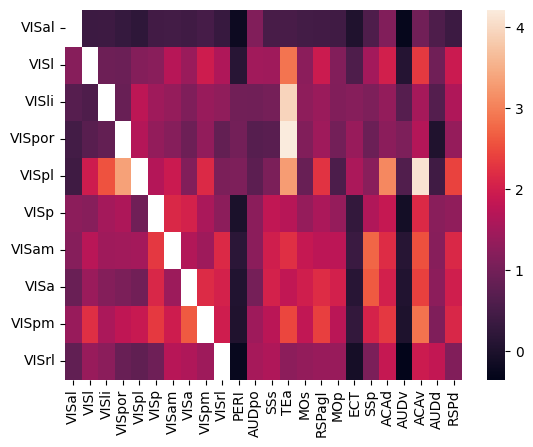

In [25]:
sb.heatmap(prob_dict_minus_shuff['homogenous_across_cubelet'])

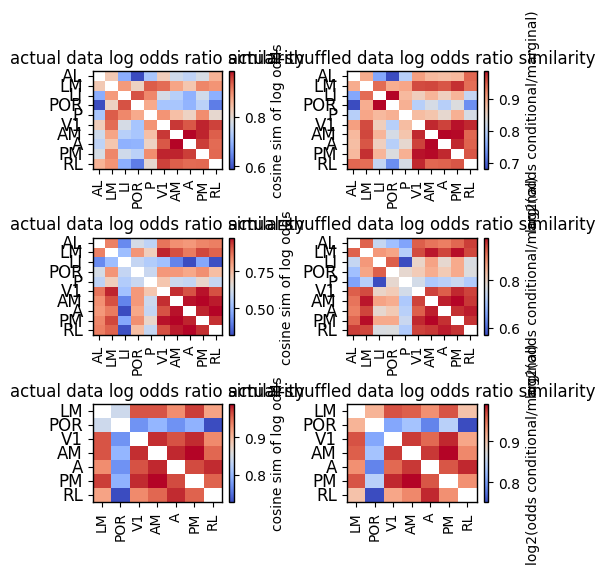

In [26]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 2, figsize=(5, 5), constrained_layout=True)
titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(analysis_names):
    actual_data= odds_dict[analysis_type]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in actual_data.columns]
    minus_shuff = prob_dict_minus_shuff[analysis_type]
    actual_cosine =  get_cosine_sim_of_probs(matrix= actual_data, cols = cols)
    minus_shuf_cosine= get_cosine_sim_of_probs(matrix= minus_shuff, cols = cols)
    sb.heatmap(
                ax=axs[analysis_num, 0], 
                data=fpf.convert_matrix_names(actual_cosine), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'cosine sim of log odds'})
    axs[analysis_num, 0].set_title(f'actual data log odds ratio similarity')   
    sb.heatmap(
                ax=axs[analysis_num, 1], 
                data=fpf.convert_matrix_names(minus_shuf_cosine), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal)'})
    axs[analysis_num, 1].set_title(f'actual-shuffled data log odds ratio similarity')   
    axs[analysis_num, 1].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    for num in [0, 1]:
        axs[analysis_num, num].tick_params(axis='y', which='major', labelsize=12, rotation=0)  
        for _, spine in axs[analysis_num, num].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, num].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

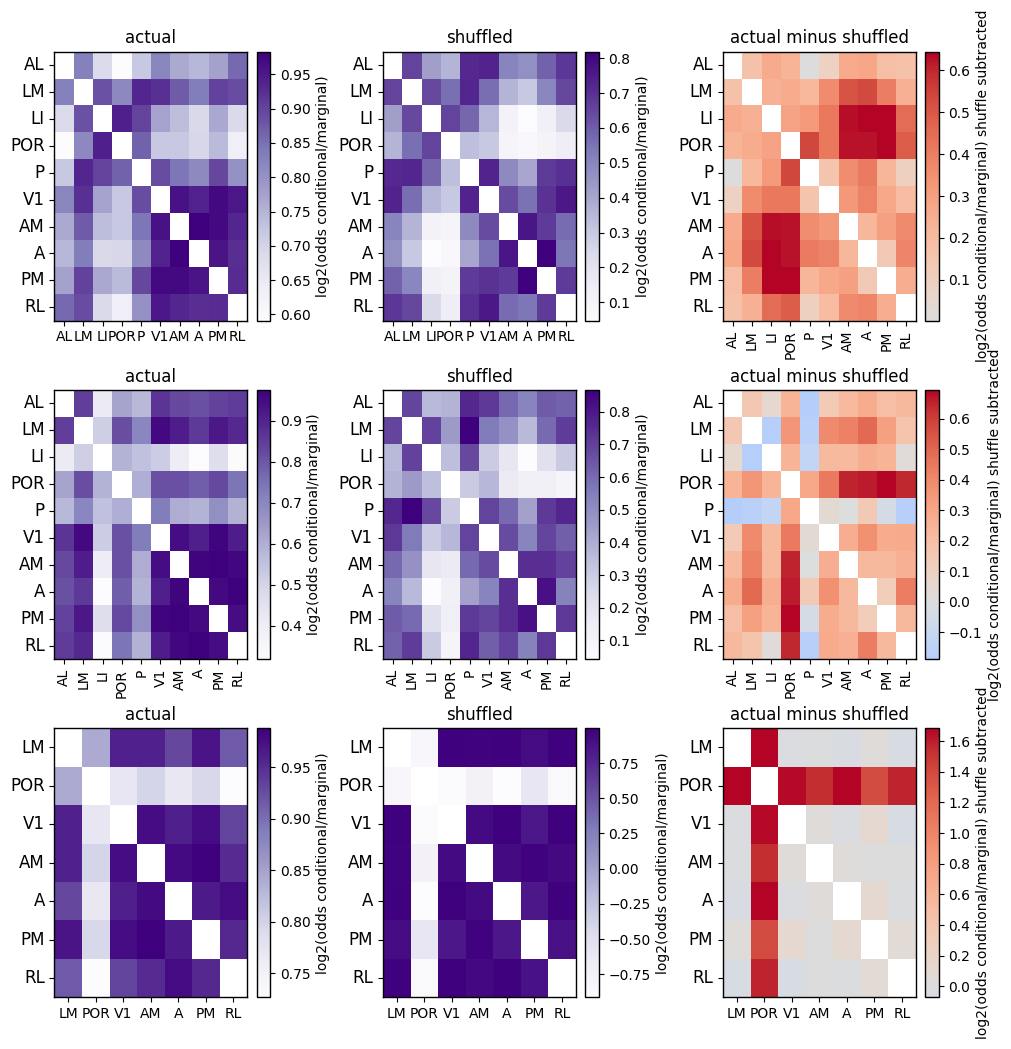

In [25]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(analysis_names):
    actual_data= odds_dict[analysis_type]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in actual_data.columns]
    dfs = [actual_data, odds_dict[f'{analysis_type}_shuffled'], actual_data]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        
        if number>1:
            dif =  get_cosine_sim_of_probs(matrix= dfs[0], cols = cols,) - get_cosine_sim_of_probs(matrix= dfs[1], cols = cols)
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(dif), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal) shuffle subtracted'})
        else:
            cosim_matrix = get_cosine_sim_of_probs(matrix= data_to_use, cols = cols)
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(cosim_matrix), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal)'})
        axs[analysis_num, number].set_title(f'{titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [10]:
number

1

In [15]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob
def get_marginal_prob(matrix, columns):
    """ function to get the marginal probability for a neuron projecting to a given area (column)"""
    marginal_prob = {}
    for area in columns:
        marginal_prob[area] = matrix.astype(bool)[area].sum()/(len(matrix))

    return marginal_prob

In [ ]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
for key in analysis_names:
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy()
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    if 'shuff' in key:
        which = key.split('shuff_')[-1]
        #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        if which in ('cubelet', 'area'):
            matrix_to_comp = all_combined[f'homogenous_across_{which}']
        elif which == 'main':
            matrix_to_comp= all_combined['area_is_main']
        conditional_prob = get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
        shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
        mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for column_name in shuffled_cond_prob.columns:
            separated_words = column_name.split(', ')
            mean_corr = shuffled_cond_prob[column_name].mean()
            if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
                # if separated_words[1] in cols:
                #     mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
                val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
                if val_to_comp >= mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                elif val_to_comp < mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                # if separated_words[1] in cols_reordered:
                #     p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        np.fill_diagonal(mean_val_matrix.values, np.nan)
        np.fill_diagonal(p_val_matrix.values, np.nan)
        number_tests = len(cols)* (len(cols_reordered)-1)
        p_val_matrix = p_val_matrix*number_tests #bonferroni correction
        p_val_dict[key] =p_val_matrix
        conditional_probability_dict[key] =mean_val_matrix
    else:
       conditional_probability_dict[key] = get_cond_prob(matrix=all_combined[key][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    

In [ ]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(3, 3, figsize=(25, 10), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        axs[analysis_num, number].set_title(f'{titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if analysis_type != 'main':
            if number>1:
                for ii in data_to_use.index:
                    for j in data_to_use.columns:
                        if p_val_dict[f'shuff_{analysis_type}'].loc[ii, j] > 0.05:
                            row_idx = data_to_use.index.get_loc(ii)  # get the index of the row name
                            col_idx = data_to_use.columns.get_loc(j)  
                            axs[analysis_num, number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [ ]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(3, 3, figsize=(25, 10), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type != 'main':
        matrix = all_combined[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        matrix = all_combined['area_is_main']
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    actual = get_cond_prob(matrix=matrix[cols_reordered], columns=cols_reordered, index=cols_reordered) 
    actual_marginal = get_marginal_prob(matrix=matrix, columns=cols_reordered)
    actual_marg = actual.copy(deep=True)
    for col in actual.columns:
        actual_marg[col] = actual_marg[col]/actual_marginal[col]
    shuff_matrix = all_combined[f'shuff_{analysis_type}']
    shuff = get_cond_prob(matrix=shuff_matrix[cols_reordered], columns=cols_reordered, index=cols_reordered) 
    shuff_marginal = get_marginal_prob(matrix=shuff_matrix, columns=cols_reordered)
    shuff_marg = shuff.copy(deep=True)
    for col in actual.columns:
        shuff_marg[col] = shuff_marg[col]/shuff_marginal[col]
    shuff_matrix = all_combined[f'shuff_{analysis_type}']
    actual_log = np.log2(actual_marg)
    actual_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    shuffled_log= np.log2(shuff_marg)
    shuffled_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_dif = np.log2(actual_marg - shuff_marg)
    combined_dif.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_min = min(actual_log.loc[cols].min().min(), shuffled_log.loc[cols].min().min())
    combined_max = max(actual_log.loc[cols].max().max(), shuffled_log.loc[cols].max().max())
    
    dfs = [actual_log, shuffled_log, combined_dif]
    # all_cols = actual_data.columns
    # cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True,  
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, vmin=combined_min,
                vmax=combined_max,
                cbar_kws={'label': 'log2(P(B|A)/P(B))'}
            )
        axs[analysis_num, number].set_xlabel(f'Area B')
        axs[analysis_num, number].set_ylabel(f'Area A')
        axs[analysis_num, number].set_title(f'{titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [ ]:
combined_max = max(actual_log.loc[cols].max().max(), shuffled_log.loc[cols].max().max())

In [ ]:
(actual_log.loc[cols].max().max(), shuffled_log.loc[cols].max().max())

In [ ]:
#converted to odds

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(3, 3, figsize=(25, 10), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type != 'main':
        matrix = all_combined[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        matrix = all_combined['area_is_main']
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    actual = get_cond_prob(matrix=matrix[cols_reordered], columns=cols_reordered, index=cols_reordered) 
    actual_marginal = get_marginal_prob(matrix=matrix, columns=cols_reordered)
    actual_odds =  actual/(1-actual)
    for col in actual.columns:
        odds_marginal = actual_marginal[col]/(1-actual_marginal[col])
        actual_odds[col] = actual_odds[col]/odds_marginal
        
    shuff_matrix = all_combined[f'shuff_{analysis_type}']
    shuff = get_cond_prob(matrix=shuff_matrix[cols_reordered], columns=cols_reordered, index=cols_reordered) 
    shuff_marginal = get_marginal_prob(matrix=shuff_matrix, columns=cols_reordered)
    shuff_odds =  shuff/(1-shuff)
    for col in shuff.columns:
        odds_marginal = shuff_marginal[col]/(1-shuff_marginal[col])
        shuff_odds[col] = shuff_odds[col]/odds_marginal
    shuff_matrix = all_combined[f'shuff_{analysis_type}']
    actual_log = np.log2(actual_odds)
    actual_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    shuffled_log= np.log2(shuff_odds)
    shuffled_log.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_dif = np.log2(actual_odds - shuff_odds)
    combined_dif.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_min = min(actual_log.loc[cols].min().min(), shuffled_log.loc[cols].min().min())
    combined_max = max(actual_log.loc[cols].max().max(), shuffled_log.loc[cols].max().max())
    if analysis_type=='cubelet':
        check_me = actual_log
    dfs = [actual_log, shuffled_log, combined_dif]
    # all_cols = actual_data.columns
    # cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True,  
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, vmin=combined_min,
                vmax=combined_max,
                cbar_kws={'label': 'log2(P(B|A)/P(B))'}
            )
        axs[analysis_num, number].set_xlabel(f'Area B')
        axs[analysis_num, number].set_ylabel(f'Area A')
        axs[analysis_num, number].set_title(f'{titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

Text(0.5, 0.98, 'min max proj bc count = 20')

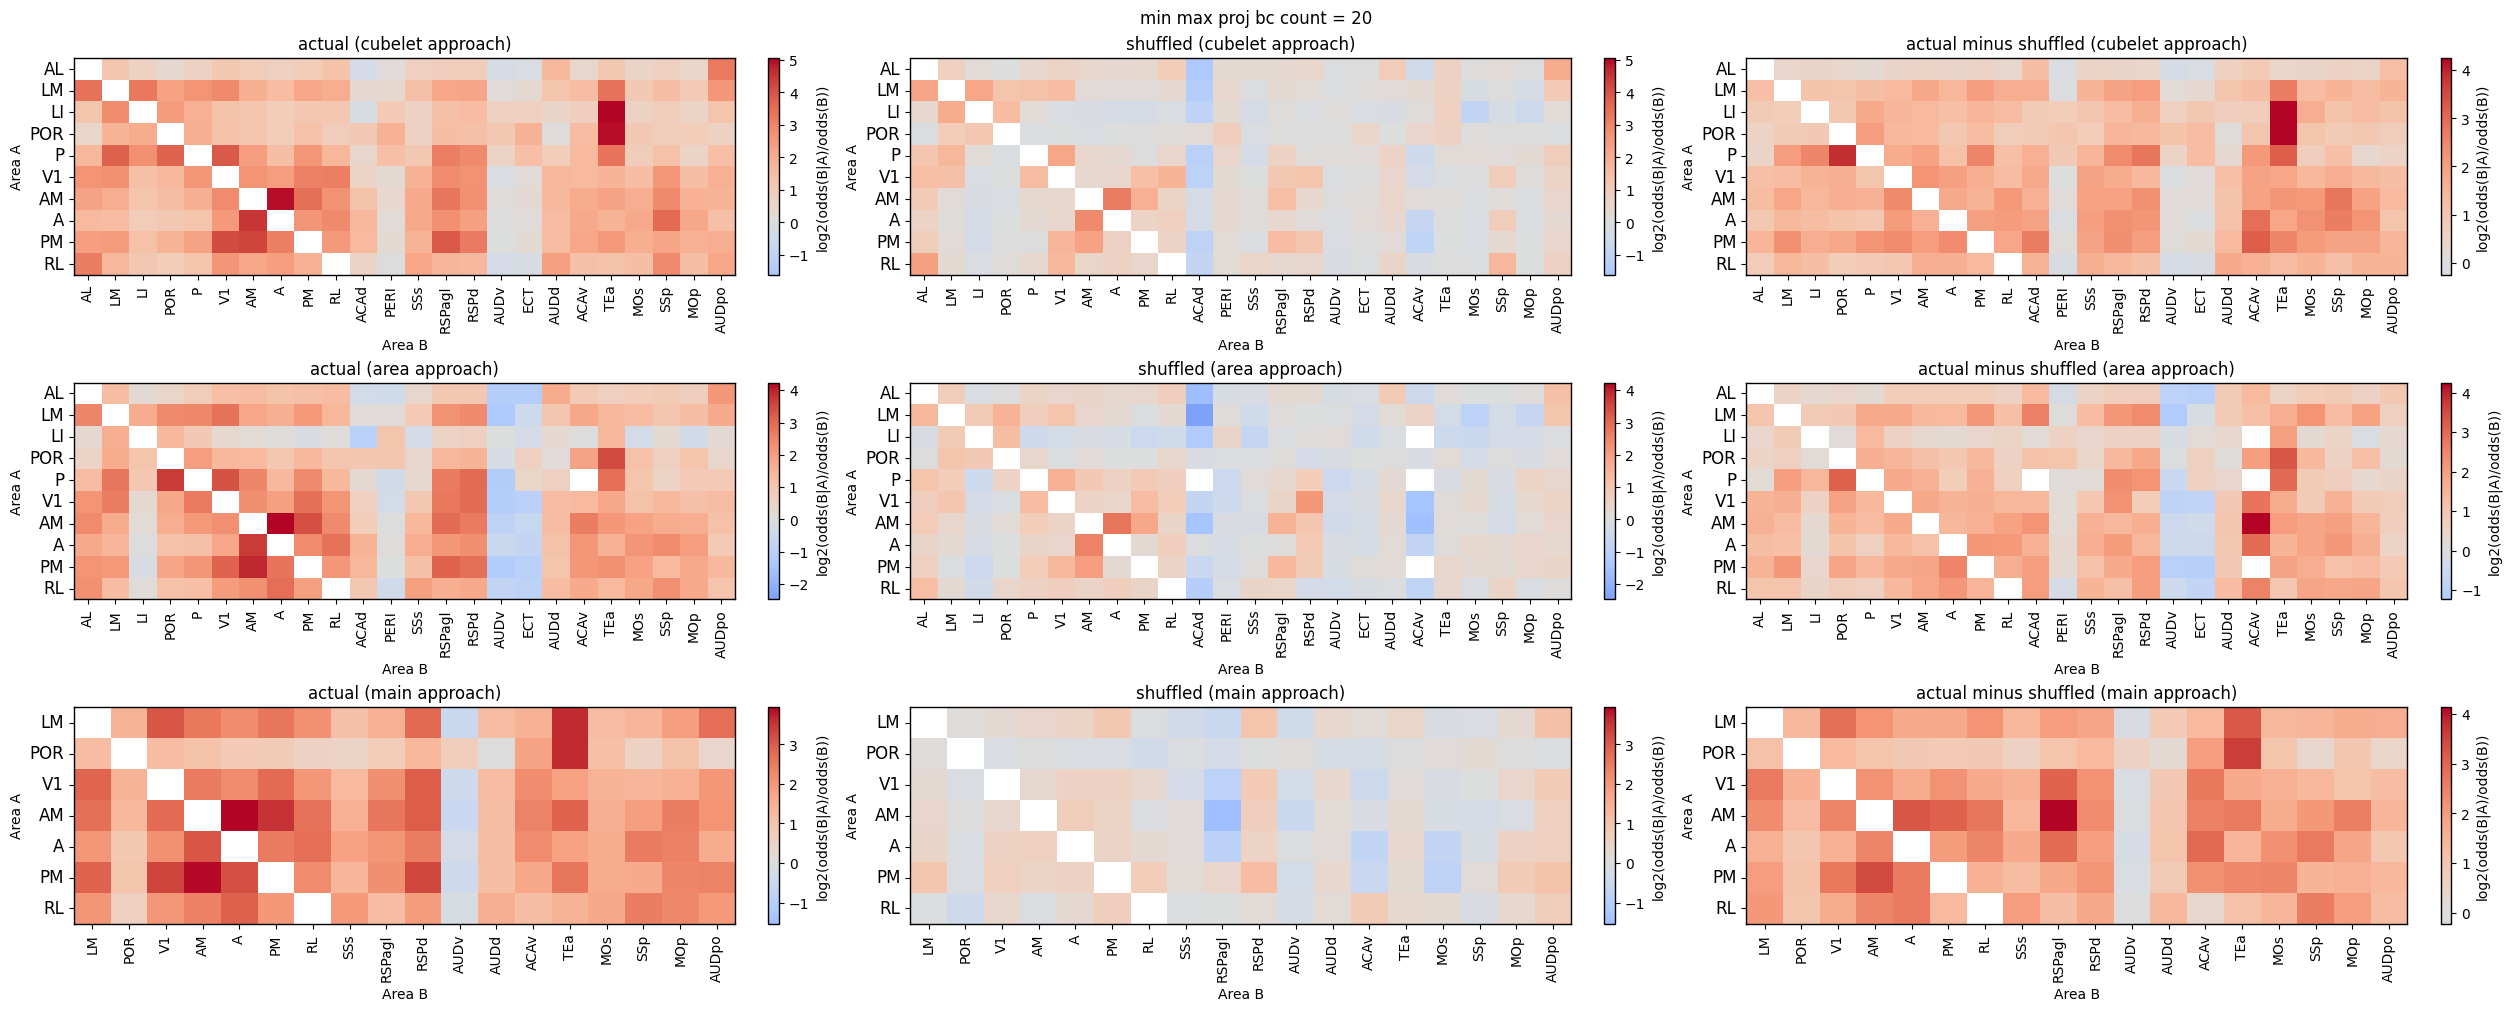

In [17]:
#converted to odds

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(3, 3, figsize=(25, 10), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type != 'main':
        matrix = all_combined[f'homogenous_across_{analysis_type}']
    else:
        matrix = all_combined['area_is_main']
        
    # Define columns and reorder them
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    
    # Calculate actual odds
    actual = get_cond_prob(matrix=matrix[cols_reordered], columns=cols_reordered, index=cols_reordered)
    actual_marginal = get_marginal_prob(matrix=matrix, columns=cols_reordered)
    actual_odds = actual / (1 - actual)  # Reset each loop
    for col in actual.columns:
        odds_marginal = actual_marginal[col] / (1 - actual_marginal[col])
        actual_odds[col] = actual_odds[col] / odds_marginal
    
    # Calculate shuffled odds
    shuff_matrix = all_combined[f'shuff_{analysis_type}']
    shuff = get_cond_prob(matrix=shuff_matrix[cols_reordered], columns=cols_reordered, index=cols_reordered)
    shuff_marginal = get_marginal_prob(matrix=shuff_matrix, columns=cols_reordered)
    shuff_odds = shuff / (1 - shuff)  # Reset each loop
    for col in shuff.columns:
        odds_marginal = shuff_marginal[col] / (1 - shuff_marginal[col])
        shuff_odds[col] = shuff_odds[col] / odds_marginal
    
    # Log transformations with replacement of inf values
    actual_log = np.log2(actual_odds).replace([np.inf, -np.inf], np.nan)
    shuffled_log = np.log2(shuff_odds).replace([np.inf, -np.inf], np.nan)
    
    # Calculate combined_dif with minimum clipping to avoid inf
    combined_dif = actual_log-shuffled_log
    
    # Determine shared min and max for the first two heatmaps
    combined_min = min(actual_log.loc[cols].min().min(), shuffled_log.loc[cols].min().min())
    combined_max = max(actual_log.loc[cols].max().max(), shuffled_log.loc[cols].max().max())
    
    dfs = [actual_log, shuffled_log, combined_dif]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        
        # Plot heatmaps with a consistent color range for the first two
        if number < 2:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data),
                cmap='coolwarm',center=0, vmin=combined_min, vmax=combined_max,
                xticklabels=True, yticklabels=True, 
                cbar_kws={'label': 'log2(odds(B|A)/odds(B))'}
            )
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, yticklabels=True,  
                cbar_kws={'label': 'log2(odds(B|A)/odds(B))'}
            )
        
        axs[analysis_num, number].set_xlabel('Area B')
        axs[analysis_num, number].set_ylabel('Area A')
        axs[analysis_num, number].set_title(f'{title} ({analysis_type} approach)')
        
        # Customize axis and colorbar
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)
plt.suptitle('min max proj bc count = 10')